In [196]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

from numpy.random import seed
from tensorflow import set_random_seed

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix

from keras.models import Sequential
from keras.layers import Dense
from keras.models import Sequential
from keras.layers.core import Dense, Activation
from keras.optimizers import SGD, Adam, Adagrad
from keras.callbacks import EarlyStopping

%matplotlib inline

# Seeding the random state for reproducibility
rand_state = 712
seed(rand_state)
set_random_seed(rand_state)

The data set that I used in this homework is the [Wearable Computing: Classification of Body Postures and Movements (PUC-Rio) Data Set](https://archive.ics.uci.edu/ml/datasets/Wearable+Computing%3A+Classification+of+Body+Postures+and+Movements+(PUC-Rio)).  Each sample in this data set consists of 12 accelerometer measurements (x, y, and z component acceleration measurements from 4 accelerometers) as a subject wearing the accelerometers is performing a body movement or posture (sitting-down, standing-up, standing, walking, or sitting).  The label for each sample is the body movement/posture being performed at that point in time.

### Loading and Cleaning the Dataset

In this section I used the Pandas module to load the data set from a csv file and then subequently perform some pre-processing steps on the data set (which are detailed in the markdown cells of this section).

In [3]:
# Read data set from csv and display some sample rows
data_path = './data/dataset-har-PUC-Rio-ugulino.csv'
df = pd.read_csv(data_path, sep=';')
df.tail()

/Users/galenpogoncheff/anaconda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3051: DtypeWarning: Columns (17) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,user,gender,age,how_tall_in_meters,weight,body_mass_index,x1,y1,z1,x2,y2,z2,x3,y3,z3,x4,y4,z4,class
165628,jose_carlos,Man,75,"1,67",67,"24,0",2,93,-148,-8,88,-100,15,120,-100,-189,-77,-160,walking
165629,jose_carlos,Man,75,"1,67",67,"24,0",-1,94,-147,-17,87,-99,17,121,-99,-190,-78,-158,walking
165630,jose_carlos,Man,75,"1,67",67,"24,0",-10,93,-143,-19,86,-104,0,114,-101,-185,-80,-153,walking
165631,jose_carlos,Man,75,"1,67",67,"24,0",-15,86,-152,-19,88,-117,-44,155,-25,-185,-84,-156,walking
165632,jose_carlos,Man,75,"1,67",67,"24,0",-14,86,-144,-18,85,-107,-3,114,-128,-210,-88,-148,walking


In [4]:
print('There are {} samples in this data set'.format(len(df)))
print()
# Get list of the class labels
print('Classes in dataset:')
print(list(df['class'].unique()))

There are 165633 samples in this data set

Classes in dataset:
['sitting', 'sittingdown', 'standing', 'standingup', 'walking']


In [5]:
print('Pandas infered data types of each feature:')
df.dtypes

Pandas infered data types of each feature:


user                  object
gender                object
age                    int64
how_tall_in_meters    object
weight                 int64
body_mass_index       object
x1                     int64
y1                     int64
z1                     int64
x2                     int64
y2                     int64
z2                     int64
x3                     int64
y3                     int64
z3                     int64
x4                     int64
y4                     int64
z4                    object
class                 object
dtype: object

It is odd that `z4` was interpreted to be of type *object*.  Let's take a look at the unique values of this feature to see if any odd values stand out:

In [7]:
df['z4'].unique()

array([-147, -145, -144, -142, -143, -146, -138, -139, -141, -133, -134,
       -135, -140, -137, -148, -151, -149, -150, -152, -156, -157, -155,
       -154, -153, -158, -159, -162, -163, -161, -160, -164, -165, -136,
       -126, -125, -122, -132, -167, -170, -169, -175, -173, -166, -168,
       -171, -172, -174, -179, -177, -176, -127, -131, -184, -181, -178,
       -180, -106, -114, -116, -115, -89, -79, -93, -78, -128, -109, -113,
       -119, -102, -111, -103, -130, -129, -182, -121, -186, -183, -187,
       -190, -188, -189, -185, -192, -191, -193, -194, -197, -196, -201,
       -251, -195, -199, -198, -123, -124, -112, -118, -120, -99, -95,
       -68, -110, -117, -96, -100, -105, -92, -88, -107, -213, -108, -104,
       -98, -94, -91, -97, -69, -101, -86, -82, -66, -77, -90, -56, -74,
       -83, -81, -219, -200, '-158', '-165', '-157', '-160', '-161',
       '-155', '-162', '-156', '-159', '-163', '-168', '-170', '-166',
       '-172', '-177', '-171', '-169', '-173', '-167', 

One of the values is **-14420-11-2011 04:50:23.713**.  This does not correspond to an accelerometer value.  Since this data set has 165,633 samples, it is probably safe to simply remove this problematic sample.

In [6]:
bad_sample_index = df[df['z4'] == '-14420-11-2011 04:50:23.713'].index
df.drop(bad_sample_index, inplace=True)

The columns `gender`, `how_tall_in_meters`, `body_mass_index`, and `z4` were read into the pandas dataframe as strings.  These features should, however, be numeric values for our classifier.  The same is true for the class label - this should be a categorical value instead of a string.  Additional adjustments that must be made include substituting the comma in the `how_tall_in_meters` and `body_mass_index` features (which use the comma as a decimal separator) for a decimal point and converting the `gender` string identifier to an int (0 to denote male, 1 to denote female).  These edits will be made prior to type casting the features.

I perform these steps in the cell below.

In [7]:
# Convert class labels to categorical values
label_dict = {'sitting': 0, 'sittingdown': 1, 'standing': 2, 'standingup': 3, 'walking': 4}
inv_label_dict = {class_id: class_string for class_string, class_id in label_dict.items()}

df['class'] = df['class'].apply(lambda class_label: label_dict[class_label])

# Replace comma in 'how_tall_in_meters' and 'body_mass_index' colums with a decimal point
df['how_tall_in_meters'] = df['how_tall_in_meters'].apply(lambda height: height.replace(',', '.'))
df['body_mass_index'] = df['body_mass_index'].apply(lambda height: height.replace(',', '.'))

# Convert the 'gender' feature to an integer value
df['gender'] = df['gender'].apply(lambda gender: 0 if gender == 'Man' else 1)

# Type cast the columns appropriately
df = df.astype({'gender': int, 'age': float, 'how_tall_in_meters': float, \
                'weight': float, 'body_mass_index': float, 'x1': float, \
                'y1': float, 'z1': float, 'x2': float, 'y2': float, \
                'z2': float, 'x3': float, 'y3': float, 'z3': float, \
                'x4': float, 'y4': float, 'z4': float, 'class': int})

Knowing the name of the subject will not help in our classification task since our goal is to train a classifier that can generalize well to unseen data, and the name of a person is not indicative of their movement behavior.  Similarly, the goal of this task is to classify the behavior of the human based on the acquired accelerometer data, so, the gender, age, height, weight, and BMI of the four individuals in this dataset are irrelevant to the task and may even hinder the ability of the model to generalize.  As such, these features (`user`, `gender`, `age`, `how_tall_in_meters`, `weight`, and `body_mass_index`) will be removed from the data set.

In [8]:
df.drop(['user', 'gender', 'age', 'how_tall_in_meters', 'weight', 'body_mass_index'], axis=1, inplace=True)

In [9]:
df.tail(10)

,x1,y1,z1,x2,y2,z2,x3,y3,z3,x4,y4,z4,class
165623,-3.0,96.0,-147.0,6.0,81.0,-90.0,15.0,120.0,-118.0,-200.0,-80.0,-166.0,4
165624,-10.0,94.0,-149.0,-10.0,87.0,-95.0,12.0,121.0,-117.0,-189.0,-81.0,-159.0,4
165625,-8.0,94.0,-150.0,-8.0,89.0,-104.0,14.0,119.0,-101.0,-193.0,-77.0,-153.0,4
165626,-6.0,96.0,-142.0,-2.0,91.0,-103.0,14.0,121.0,-102.0,-194.0,-78.0,-156.0,4
165627,-13.0,94.0,-150.0,-13.0,88.0,-98.0,16.0,120.0,-99.0,-194.0,-79.0,-157.0,4
165628,2.0,93.0,-148.0,-8.0,88.0,-100.0,15.0,120.0,-100.0,-189.0,-77.0,-160.0,4
165629,-1.0,94.0,-147.0,-17.0,87.0,-99.0,17.0,121.0,-99.0,-190.0,-78.0,-158.0,4
165630,-10.0,93.0,-143.0,-19.0,86.0,-104.0,0.0,114.0,-101.0,-185.0,-80.0,-153.0,4
165631,-15.0,86.0,-152.0,-19.0,88.0,-117.0,-44.0,155.0,-25.0,-185.0,-84.0,-156.0,4
165632,-14.0,86.0,-144.0,-18.0,85.0,-107.0,-3.0,114.0,-128.0,-210.0,-88.0,-148.0,4


Let's now make sure that we have no NaN values in out data set:

In [10]:
df.isnull().values.any()

False

Our data is now ready for use (aside from splitting it into training/test sets, normalization, etc).  Let's copy it into a numpy array for further use in our neural network.

In [11]:
dataset = df.to_numpy()

___

### Visualizing the Data Set

Since all 12 dimensions of the data set cannot be visualized at once, I provide 4 separate 3-dimesional figures below.  Each figure is associated with the x, y, and z values from one of the four accelerometers.  In each of the figures below, the samples are colored by class.

In [49]:
accelerometer1_data = dataset[:, np.array([0, 1, 2, -1])]
accelerometer2_data = dataset[:, np.array([3, 4, 5, -1])]
accelerometer3_data = dataset[:, np.array([6, 7, 8, -1])]
accelerometer4_data = dataset[:, np.array([9, 10, 11, -1])]
accelerometers = [accelerometer1_data, accelerometer2_data, \
                  accelerometer3_data, accelerometer4_data]

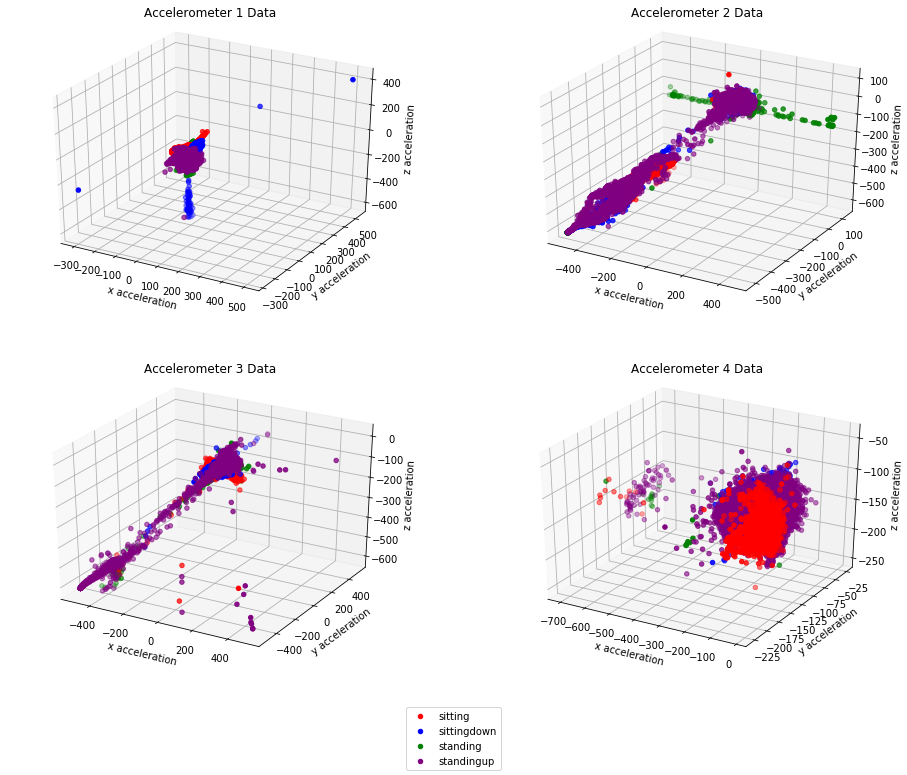

In [69]:
fig = plt.figure(figsize=(16, 12))
ax1 = fig.add_subplot(2, 2, 1, projection='3d')
ax2 = fig.add_subplot(2, 2, 2, projection='3d')
ax3 = fig.add_subplot(2, 2, 3, projection='3d')
ax4 = fig.add_subplot(2, 2, 4, projection='3d')

for data, axis in zip(accelerometers, [ax1, ax2, ax3, ax4]):
    for class_i, col in enumerate(['red', 'blue', 'green', 'purple']):
        class_data = data[np.where(data[:,-1] == class_i)]
        axis.scatter(class_data[:,0], class_data[:,1], class_data[:,2], \
                     color=col, label=inv_label_dict[class_i])
    axis.set_xlabel('x acceleration')
    axis.set_ylabel('y acceleration')
    axis.set_zlabel('z acceleration')

ax1.set_title('Accelerometer 1 Data', pad=20)
ax2.set_title('Accelerometer 2 Data', pad=20)
ax3.set_title('Accelerometer 3 Data', pad=20)
ax4.set_title('Accelerometer 4 Data', pad=20)

handles, labels = ax1.get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center')

plt.show()

Since the figures above do not give a clear indication of the presence of hyperplanes that may separate the data by class, it is more likely that the data may be separable in a higher dimensional space than cannot be easily visualized.

The boxplots below offer a high level overview of the distribution of each feature among the samples of each class.  We can roughly observe that the samples corresponding to the body motions *sitting down* and *standing up* have fairly similar distributions for each feature.

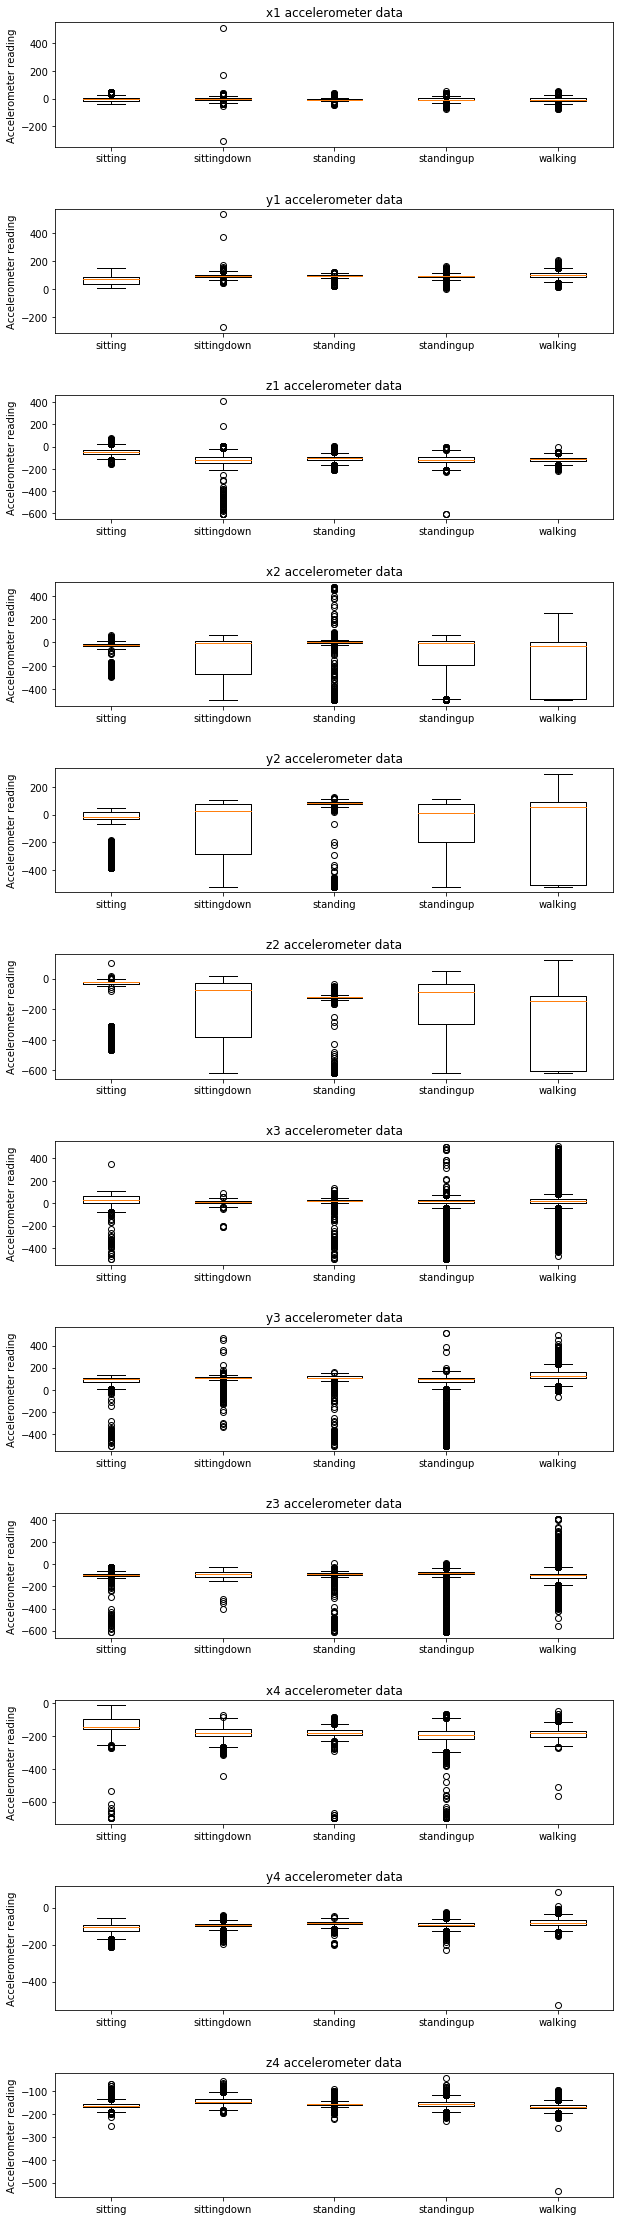

In [229]:
fig, ax = plt.subplots(12, figsize=(10, 40))

class_datasets = [dataset[np.where(data[:,-1] == i)] for i in range(0, 5)]
features = ['x1', 'y1', 'z1', 'x2', 'y2', 'z2', \
            'x3', 'y3', 'z3', 'x4', 'y4', 'z4']

for i, axis in enumerate(ax):
    ax[i].boxplot([class_data[:,i] for class_data in class_datasets])
    ax[i].set_title('{} accelerometer data'.format(features[i]))
    ax[i].set_ylabel('Accelerometer reading')
    ax[i].set_xticklabels(list(label_dict.keys()))

fig.subplots_adjust(hspace=.5)

plt.show()

___

### Preparing the Data Set for Training and Evaluation

In [71]:
X = dataset[:, :-1]
y = dataset[:, -1]

# Split the dataset into train and test sets (70% train, 30% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, test_size=0.3)

In [72]:
print('Number of instances in the training set: {}'.format(X_train.shape[0]))
print('Number of instances in the test set: {}'.format(X_test.shape[0]))
print()
print('Number of features for each instance: {}'.format(X_train.shape[1]))

Number of instances in the training set: 115942
Number of instances in the test set: 49690

Number of features for each instance: 12


In [187]:
# Save the training and test sets to a file for easy loading in future use
#np.save('./data/X_train.npy', X_train)
#np.save('./data/X_test.npy', X_test)
#np.save('./data/y_train.npy', y_train)
#np.save('./data/y_test.npy', y_test)

In [230]:
# Load pre-processed data sets
#X_train = np.load('./data/X_train.npy')
#X_test = np.load('./data/X_test.npy')
#y_train = np.load('./data/y_train.npy')
#y_test = np.load('./data/y_test.npy')

Before using the this data for training and testing, it is importatant to normalize the data.  Consider sample $x_i$ of the training set with 12-dimensional feature vector $< x_{i,0}, x_{i,1}, x_{i,2}, ..., x_{i,11}>$.  For each sample $i$, the $j^{th}$ feature, $x_{i,j}$ of this vector will be transformed according to

$$
x'_{i, j} = \frac{x_{i, j} - x_{min_j}}{x_{max_j} - x_{min_j}},
$$

where $x_{min_j}$ is the minimum value of feature $j$ in the training set and $x_{max_j}$ is the maximum value of feature $j$ in the training set.  Applying this transformation to each sample of the training set will normalize the features of the training set to the range $[0, 1]$.  This same transformation (using the values of $x_{min_j}$ and $x_{max_j}$ from the training set) will be made to all of the samples in the test set as well so that they can be fed through our trained neural network when performing inference on the test data.  This is easily done with sklearn's MinMaxScaler!

In [189]:
scaler_01 = MinMaxScaler()
scaler_01.fit(X_train)

X_train = scaler_01.transform(X_train)
X_test = scaler_01.transform(X_test)

Finally, since out neural network will have a softmax function applied at its output layer, lets encode our training and test labels using one hot encoding:

In [190]:
onehot_encoder = OneHotEncoder(categories='auto')
onehot_encoder.fit(y_train.reshape(-1,1))
y_train = onehot_encoder.transform(y_train.reshape(-1,1))
y_test = onehot_encoder.transform(y_test.reshape(-1,1))

___

### Model Tuning

In constructing a neural network classifier for this data set (below), I experimented with various architectural and optimization specifications to achieve a highly accurate network.  Specifically, in my experimentaion, I tried adjusting the number of layers in the network, the number of units in these layers, the activations functions in the network, the optimizer used in training the network and its learning rate, the training batch size, and the network's loss function.  Since this data set that I am using is tabular with no time or spatial component, I only consider using a fully connected neural network in these experiments.

In order to evaluate how these parameters affect the network's performance, I trained networks with different combinations of these configurations, meanwhile recording the validation accuracy that is achieved after training the network (for a maximum of 250 epochs).  During this process I enforce an early stopping mechanism on the model's training process, such that if the validation accuracy does not improve for a specified number of epochs, the model training will complete.  This mechanism is one step towards preventing overfitting.  The architecture that offered the highest accuracy on the validation set was the final chosen architecture.

After I felt that I had estabished a good network architecture, training specifications such as the batch size and loss function were finally evaluated for effeciency (i.e., computation time) and accuracy, respectively.

Given that these parameters were tuned to maximize classification accuracy on validation sets, it is quite possible that overfitting occured as a result. After completing these experiments, I evaluated my final model on the held-out test data set to see how well it generalizes to a collection of unseen data samples.

#### 1. Architecture Tuning

In [77]:
# Early stopping mechanism - monitor the validation loss throughout the training process.
# If this loss doesnt decrease in 20 epochs, halt training
early_stopper = EarlyStopping(monitor='val_loss', mode='min', patience=20, min_delta=.01)

The dataset has 12 input features and 5 possible output labels.  As such, the first layer of the model will have an input dimension of size (12,), while the output layer will have 5 units.  Since we are performing multi-class classification, I will apply a softmax activation function to the output of this output layer.  Additionally, I will begin by using the categorical cross entropy loss function, since it is well suited to training a classifier for multi-class classification.

Let's first try a simple shallow network with one layer consisting of 5 units:

In [79]:
model = Sequential()
model.add(Dense(5, input_shape=(12,), kernel_initializer='random_uniform'))
model.add(Activation('softmax'))
model.summary()

model.compile(loss='categorical_crossentropy', optimizer=SGD(), metrics=['categorical_accuracy'])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 5)                 65        
_________________________________________________________________
activation_2 (Activation)    (None, 5)                 0         
Total params: 65
Trainable params: 65
Non-trainable params: 0
_________________________________________________________________


Now I'll train the simple model with early stopping.  A batch size of 2048 splits the training set into roughly 42.3 batches.  I'll use this batch size as a starting point, and potentially adjust it later.

In [80]:
history = model.fit(X_train, y_train, batch_size=2048, epochs=250, verbose=1, \
                    validation_split=0.2, callbacks=[early_stopper])

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where

Train on 92753 samples, validate on 23189 samples
Epoch 1/250
92753/92753 [==============================] - 0s 3us/step - loss: 1.5715 - categorical_accuracy: 0.2542 - val_loss: 1.5256 - val_categorical_accuracy: 0.2841
Epoch 2/250
92753/92753 [==============================] - 0s 1us/step - loss: 1.5031 - categorical_accuracy: 0.3256 - val_loss: 1.4814 - val_categorical_accuracy: 0.2862
Epoch 3/250
92753/92753 [==============================] - 0s 1us/step - loss: 1.4721 - categorical_accuracy: 0.3116 - val_loss: 1.4596 - val_categorical_accuracy: 0.3212
Epoch 4/250
92753/92753 [==============================] - 0s 1us/step - loss: 1.4560 - categorical_accuracy: 0.3092 - val_loss: 1.4473 - val_categorical_accuracy: 0.3084
Epoch 5/250
92753/92753 [==============================] - 0s 1us/step - loss: 1.4465 - categorical_accuracy: 0.3061 - val_loss: 1.4392 - val_categorical_accuracy: 0.3084


During the training process above, the loss decreases at a very slow rate.  This may be indicative of the fact that the parameter updates are too small at each epoch.  Below I try training the same architecture except with a SGD learning rate of 0.1 (as opposed to 0.01).

In [82]:
model = Sequential()
model.add(Dense(5, input_shape=(12,), kernel_initializer='random_uniform'))
model.add(Activation('softmax'))
# Increase the learning rate of the SGD optimizer from 0.01 to 0.1
model.compile(loss='categorical_crossentropy', optimizer=SGD(lr=0.1), metrics=['categorical_accuracy'])

history = model.fit(X_train, y_train, batch_size=2048, epochs=250, verbose=1, \
                    validation_split=0.2, callbacks=[early_stopper])

Train on 92753 samples, validate on 23189 samples
Epoch 1/250
92753/92753 [==============================] - 0s 3us/step - loss: 1.4551 - categorical_accuracy: 0.3505 - val_loss: 1.4162 - val_categorical_accuracy: 0.4160
Epoch 2/250
92753/92753 [==============================] - 0s 2us/step - loss: 1.4091 - categorical_accuracy: 0.4404 - val_loss: 1.3926 - val_categorical_accuracy: 0.4718
Epoch 3/250
92753/92753 [==============================] - 0s 1us/step - loss: 1.3885 - categorical_accuracy: 0.4968 - val_loss: 1.3738 - val_categorical_accuracy: 0.6177
Epoch 4/250
92753/92753 [==============================] - 0s 2us/step - loss: 1.3716 - categorical_accuracy: 0.5957 - val_loss: 1.3583 - val_categorical_accuracy: 0.3791
Epoch 5/250
92753/92753 [==============================] - 0s 2us/step - loss: 1.3574 - categorical_accuracy: 0.5807 - val_loss: 1.3447 - val_categorical_accuracy: 0.6208
Epoch 6/250
92753/92753 [==============================] - 0s 1us/step - loss: 1.3451 - categor

In [83]:
final_epoch_val_acc = history.history['val_categorical_accuracy'][-1]
final_epoch = len(history.history['val_categorical_accuracy'])
print('{}% validation accuracy achieved after {} epochs of training'\
      .format(round(final_epoch_val_acc, 5)*100, final_epoch))

70.745% validation accuracy achieved after 250 epochs of training


Increasing the learning rate enabled the simple model to achieve a better performance (as measured on the validation set) in the same number of epochs.  However, after 250 training epochs, the simple model only achieved a classifiaction accuracy of about 70%.  Adding more flexibility to the model (via additional layers and units) shoud allow better performance.  Below, I test the use of three layers with 24, 24, and 5 units, respectively with sigmoid activation functions and then with relu activation functions.

In [84]:
# 3 layers and sigmoid activations
model = Sequential()
model.add(Dense(24, input_shape=(12,), kernel_initializer='random_uniform'))
model.add(Activation('sigmoid'))
model.add(Dense(24, kernel_initializer='random_uniform'))
model.add(Activation('sigmoid'))
model.add(Dense(5, kernel_initializer='random_uniform'))
model.add(Activation('softmax'))
model.summary()

model.compile(loss='categorical_crossentropy', optimizer=SGD(lr=.1), metrics=['categorical_accuracy'])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 24)                312       
_________________________________________________________________
activation_4 (Activation)    (None, 24)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 24)                600       
_________________________________________________________________
activation_5 (Activation)    (None, 24)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 5)                 125       
_________________________________________________________________
activation_6 (Activation)    (None, 5)                 0         
Total params: 1,037
Trainable params: 1,037
Non-trainable params: 0
_________________________________________________________________


In [85]:
history = model.fit(X_train, y_train, batch_size=2048, epochs=250, verbose=1, \
                    validation_split=0.2, callbacks=[early_stopper])

Train on 92753 samples, validate on 23189 samples
Epoch 1/250
92753/92753 [==============================] - 0s 4us/step - loss: 1.4696 - categorical_accuracy: 0.3055 - val_loss: 1.4511 - val_categorical_accuracy: 0.3084
Epoch 2/250
92753/92753 [==============================] - 0s 2us/step - loss: 1.4547 - categorical_accuracy: 0.3061 - val_loss: 1.4508 - val_categorical_accuracy: 0.3084
Epoch 3/250
92753/92753 [==============================] - 0s 2us/step - loss: 1.4547 - categorical_accuracy: 0.3061 - val_loss: 1.4506 - val_categorical_accuracy: 0.3084
Epoch 4/250
92753/92753 [==============================] - 0s 2us/step - loss: 1.4547 - categorical_accuracy: 0.3061 - val_loss: 1.4507 - val_categorical_accuracy: 0.3084
Epoch 5/250
92753/92753 [==============================] - 0s 2us/step - loss: 1.4546 - categorical_accuracy: 0.3061 - val_loss: 1.4508 - val_categorical_accuracy: 0.3084
Epoch 6/250
92753/92753 [==============================] - 0s 2us/step - loss: 1.4547 - categor

From the above training history, it appears that the optimizer got stuck. In other words, in the first 21 epochs it failed to update the model's parameters in such a way that its performance on the classification task at hand would improve.  This may have been because a plateau or local minimum was found. By using an optimizer with an adaptive learning rate during model training, we may experience better loss convergence.  In the cell below, I try training the same architecture with the Adam optimizer.

In [86]:
# Same architecture, larger learning rate
model.compile(loss='categorical_crossentropy', optimizer=Adam(), metrics=['categorical_accuracy'])

history = model.fit(X_train, y_train, batch_size=2048, epochs=250, verbose=1, \
                    validation_split=0.2, callbacks=[early_stopper])

Train on 92753 samples, validate on 23189 samples
Epoch 1/250
92753/92753 [==============================] - 0s 5us/step - loss: 1.4548 - categorical_accuracy: 0.3061 - val_loss: 1.4507 - val_categorical_accuracy: 0.3084
Epoch 2/250
92753/92753 [==============================] - 0s 2us/step - loss: 1.4546 - categorical_accuracy: 0.3061 - val_loss: 1.4505 - val_categorical_accuracy: 0.3084
Epoch 3/250
92753/92753 [==============================] - 0s 2us/step - loss: 1.4544 - categorical_accuracy: 0.3061 - val_loss: 1.4503 - val_categorical_accuracy: 0.3084
Epoch 4/250
92753/92753 [==============================] - 0s 2us/step - loss: 1.4535 - categorical_accuracy: 0.3061 - val_loss: 1.4486 - val_categorical_accuracy: 0.3084
Epoch 5/250
92753/92753 [==============================] - 0s 2us/step - loss: 1.4506 - categorical_accuracy: 0.3061 - val_loss: 1.4431 - val_categorical_accuracy: 0.3084
Epoch 6/250
92753/92753 [==============================] - 0s 2us/step - loss: 1.4394 - categor

In [87]:
final_epoch_val_acc = history.history['val_categorical_accuracy'][-1]
final_epoch = len(history.history['val_categorical_accuracy'])
print('{}% validation accuracy achieved after {} epochs of training'\
      .format(round(final_epoch_val_acc, 5)*100, final_epoch))

78.805% validation accuracy achieved after 206 epochs of training


A significant increase in validation accuracy, as compared to the simple model, is observed above.  Additionally, we notice that the Adam optimizer was able to adapt the learning rate of the parameter update process, enabling the optimizer to make progress towards minimizing the loss.

I will again try training a network of the same strucutre except with relu activation functions instead of sigmoid activation functions.

In [88]:
# 3 layers and relu activations
model = Sequential()
model.add(Dense(24, input_shape=(12,)))
model.add(Activation('relu'))
model.add(Dense(24))
model.add(Activation('relu'))
model.add(Dense(5))
model.add(Activation('softmax'))
model.summary()

model.compile(loss='categorical_crossentropy', optimizer=SGD(), metrics=['categorical_accuracy'])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_7 (Dense)              (None, 24)                312       
_________________________________________________________________
activation_7 (Activation)    (None, 24)                0         
_________________________________________________________________
dense_8 (Dense)              (None, 24)                600       
_________________________________________________________________
activation_8 (Activation)    (None, 24)                0         
_________________________________________________________________
dense_9 (Dense)              (None, 5)                 125       
_________________________________________________________________
activation_9 (Activation)    (None, 5)                 0         
Total params: 1,037
Trainable params: 1,037
Non-trainable params: 0
_________________________________________________________________


In [89]:
history = model.fit(X_train, y_train, batch_size=2048, epochs=250, verbose=1, \
                    validation_split=0.2, callbacks=[early_stopper])

Train on 92753 samples, validate on 23189 samples
Epoch 1/250
92753/92753 [==============================] - 0s 4us/step - loss: 1.5656 - categorical_accuracy: 0.2972 - val_loss: 1.5188 - val_categorical_accuracy: 0.3208
Epoch 2/250
92753/92753 [==============================] - 0s 2us/step - loss: 1.4949 - categorical_accuracy: 0.3155 - val_loss: 1.4723 - val_categorical_accuracy: 0.3091
Epoch 3/250
92753/92753 [==============================] - 0s 2us/step - loss: 1.4629 - categorical_accuracy: 0.3071 - val_loss: 1.4500 - val_categorical_accuracy: 0.3091
Epoch 4/250
92753/92753 [==============================] - 0s 2us/step - loss: 1.4469 - categorical_accuracy: 0.3070 - val_loss: 1.4383 - val_categorical_accuracy: 0.3108
Epoch 5/250
92753/92753 [==============================] - 0s 2us/step - loss: 1.4381 - categorical_accuracy: 0.3088 - val_loss: 1.4283 - val_categorical_accuracy: 0.3449
Epoch 6/250
92753/92753 [==============================] - 0s 2us/step - loss: 1.4275 - categor

In [90]:
final_epoch_val_acc = history.history['val_categorical_accuracy'][-1]
final_epoch = len(history.history['val_categorical_accuracy'])
print('{}% validation accuracy achieved after {} epochs of training'\
      .format(round(final_epoch_val_acc, 5)*100, final_epoch))

76.114% validation accuracy achieved after 250 epochs of training


The network performed slightly worse on the validation set when equipped with relu activation functions instead of sigmoid activation functions.  Another architectural adjustment will now be tested, adding even more depth to the network. Theoretically, with this added depth, the network will be able to learn a much richer function space. Below I equip the network with 7 layers, with 24, 48, 48, 48, 48, 48, and 5 units in each layer, respectively.  

In the below experiments I try training such a network with sigmoid activation functions and then with relu activation functions. In addition, I experiment with the use of a different weight initializer in the hidden layers - the [He Normal](https://medium.com/@prateekvishnu/xavier-and-he-normal-he-et-al-initialization-8e3d7a087528) initializer.  This initializes the weights in each layer to be normally distributed with a mean of 0 and standard deviation equal to
$$
\sqrt{\frac{2}{fan_{in}}}\text{ ,}
$$
where $fan_{in}$ is the number of activations each unit will receive from the previous layer.

In [91]:
# 7 layers, sigmoid activations, he normal initialization
model = Sequential()
model.add(Dense(24, input_shape=(12,), kernel_initializer='he_normal'))
model.add(Activation('sigmoid'))
model.add(Dense(48, kernel_initializer='he_normal'))
model.add(Activation('sigmoid'))
model.add(Dense(48, kernel_initializer='he_normal'))
model.add(Activation('sigmoid'))
model.add(Dense(48, kernel_initializer='he_normal'))
model.add(Activation('sigmoid'))
model.add(Dense(48, kernel_initializer='he_normal'))
model.add(Activation('sigmoid'))
model.add(Dense(48, kernel_initializer='he_normal'))
model.add(Activation('sigmoid'))
model.add(Dense(5, kernel_initializer='he_normal'))
model.add(Activation('softmax'))
model.summary()

model.compile(loss='categorical_crossentropy', optimizer=Adam(), metrics=['categorical_accuracy'])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_10 (Dense)             (None, 24)                312       
_________________________________________________________________
activation_10 (Activation)   (None, 24)                0         
_________________________________________________________________
dense_11 (Dense)             (None, 48)                1200      
_________________________________________________________________
activation_11 (Activation)   (None, 48)                0         
_________________________________________________________________
dense_12 (Dense)             (None, 48)                2352      
_________________________________________________________________
activation_12 (Activation)   (None, 48)                0         
_________________________________________________________________
dense_13 (Dense)             (None, 48)                2352      
__________

In [92]:
history = model.fit(X_train, y_train, batch_size=2048, epochs=250, verbose=1, \
                    validation_split=0.2, callbacks=[early_stopper])

Train on 92753 samples, validate on 23189 samples
Epoch 1/250
92753/92753 [==============================] - 1s 8us/step - loss: 1.4606 - categorical_accuracy: 0.3010 - val_loss: 1.4509 - val_categorical_accuracy: 0.3084
Epoch 2/250
92753/92753 [==============================] - 0s 3us/step - loss: 1.4549 - categorical_accuracy: 0.3061 - val_loss: 1.4508 - val_categorical_accuracy: 0.3084
Epoch 3/250
92753/92753 [==============================] - 0s 3us/step - loss: 1.4545 - categorical_accuracy: 0.3061 - val_loss: 1.4504 - val_categorical_accuracy: 0.3084
Epoch 4/250
92753/92753 [==============================] - 0s 3us/step - loss: 1.4535 - categorical_accuracy: 0.3061 - val_loss: 1.4473 - val_categorical_accuracy: 0.3084
Epoch 5/250
92753/92753 [==============================] - 0s 3us/step - loss: 1.4374 - categorical_accuracy: 0.3501 - val_loss: 1.3939 - val_categorical_accuracy: 0.3619
Epoch 6/250
92753/92753 [==============================] - 0s 3us/step - loss: 1.3687 - categor

After 104 training epochs (only 104 of the 250 epochs were performed due enforcement of the early stopping criteria), this model still only achieved, about 78% accuracy on the validation set.  This is no better than the previous model which had far fewer parameters.

Below, I substitute the sigmoid activation functions in this deep model for relu activation functions.

In [93]:
# 7 layers, relu activations, he normal initialization
model = Sequential()
model.add(Dense(24, input_shape=(12,), kernel_initializer='he_normal'))
model.add(Activation('relu'))
model.add(Dense(48, kernel_initializer='he_normal'))
model.add(Activation('relu'))
model.add(Dense(48, kernel_initializer='he_normal'))
model.add(Activation('relu'))
model.add(Dense(48, kernel_initializer='he_normal'))
model.add(Activation('relu'))
model.add(Dense(48, kernel_initializer='he_normal'))
model.add(Activation('relu'))
model.add(Dense(48, kernel_initializer='he_normal'))
model.add(Activation('relu'))
model.add(Dense(5, kernel_initializer='he_normal'))
model.add(Activation('softmax'))
model.summary()

model.compile(loss='categorical_crossentropy', optimizer=Adam(), metrics=['categorical_accuracy'])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_17 (Dense)             (None, 24)                312       
_________________________________________________________________
activation_17 (Activation)   (None, 24)                0         
_________________________________________________________________
dense_18 (Dense)             (None, 48)                1200      
_________________________________________________________________
activation_18 (Activation)   (None, 48)                0         
_________________________________________________________________
dense_19 (Dense)             (None, 48)                2352      
_________________________________________________________________
activation_19 (Activation)   (None, 48)                0         
_________________________________________________________________
dense_20 (Dense)             (None, 48)                2352      
__________

In [94]:
history = model.fit(X_train, y_train, batch_size=2048, epochs=250, verbose=1, \
                    validation_split=0.2, callbacks=[early_stopper])

Train on 92753 samples, validate on 23189 samples
Epoch 1/250
92753/92753 [==============================] - 1s 9us/step - loss: 1.3698 - categorical_accuracy: 0.5506 - val_loss: 1.1681 - val_categorical_accuracy: 0.6887
Epoch 2/250
92753/92753 [==============================] - 0s 3us/step - loss: 0.9646 - categorical_accuracy: 0.7128 - val_loss: 0.7708 - val_categorical_accuracy: 0.7350
Epoch 3/250
92753/92753 [==============================] - 0s 3us/step - loss: 0.7232 - categorical_accuracy: 0.7447 - val_loss: 0.6615 - val_categorical_accuracy: 0.7752
Epoch 4/250
92753/92753 [==============================] - 0s 3us/step - loss: 0.6354 - categorical_accuracy: 0.7738 - val_loss: 0.6105 - val_categorical_accuracy: 0.7793
Epoch 5/250
92753/92753 [==============================] - 0s 3us/step - loss: 0.5865 - categorical_accuracy: 0.7894 - val_loss: 0.5523 - val_categorical_accuracy: 0.8044
Epoch 6/250
92753/92753 [==============================] - 0s 3us/step - loss: 0.5458 - categor

This change made a significant difference in the model's performance (as judged by accuracy on the validation set). After 141 epochs the model achieved a validation accuracy of 95.89%.

Lets now see if a slightly higher accuracy can be obtained by increasing the number of units in a few of the hidden layers.

In [96]:
# 7 layers, relu activations, he normal initialization, more units in hidden layers
model = Sequential()
model.add(Dense(24, input_shape=(12,), kernel_initializer='he_normal'))
model.add(Activation('relu'))
model.add(Dense(48, kernel_initializer='he_normal'))
model.add(Activation('relu'))
model.add(Dense(72, kernel_initializer='he_normal'))
model.add(Activation('relu'))
model.add(Dense(72, kernel_initializer='he_normal'))
model.add(Activation('relu'))
model.add(Dense(72, kernel_initializer='he_normal'))
model.add(Activation('relu'))
model.add(Dense(72, kernel_initializer='he_normal'))
model.add(Activation('relu'))
model.add(Dense(5, kernel_initializer='he_normal'))
model.add(Activation('softmax'))

model.compile(loss='categorical_crossentropy', optimizer=Adam(), metrics=['categorical_accuracy'])
history = model.fit(X_train, y_train, batch_size=2048, epochs=250, verbose=1, \
                    validation_split=0.2, callbacks=[early_stopper])

Train on 92753 samples, validate on 23189 samples
Epoch 1/250
92753/92753 [==============================] - 1s 11us/step - loss: 1.1890 - categorical_accuracy: 0.6062 - val_loss: 0.9084 - val_categorical_accuracy: 0.7010
Epoch 2/250
92753/92753 [==============================] - 0s 3us/step - loss: 0.7990 - categorical_accuracy: 0.7012 - val_loss: 0.7154 - val_categorical_accuracy: 0.7242
Epoch 3/250
92753/92753 [==============================] - 0s 3us/step - loss: 0.6661 - categorical_accuracy: 0.7511 - val_loss: 0.6010 - val_categorical_accuracy: 0.7748
Epoch 4/250
92753/92753 [==============================] - 0s 3us/step - loss: 0.5772 - categorical_accuracy: 0.7871 - val_loss: 0.5729 - val_categorical_accuracy: 0.7921
Epoch 5/250
92753/92753 [==============================] - 0s 3us/step - loss: 0.5267 - categorical_accuracy: 0.8053 - val_loss: 0.4923 - val_categorical_accuracy: 0.8226
Epoch 6/250
92753/92753 [==============================] - 0s 3us/step - loss: 0.4885 - catego

This model achieved an slight increase in validation accuracy at the expense of a slighty longer training time and a greater number of total parameters.

Before evaluating the effect of the batch size on the total training time, I experiment with using a different loss function, [KL-divergence](https://en.wikipedia.org/wiki/Kullback–Leibler_divergence) below, while all other components of the network remain identical to the previous network.  As observable below, with all other parameters unchanged, using this loss function did not improve the validation accuracy.

In [99]:
# 7 layers, relu activations, he normal initialization, more units in hidden layers
model = Sequential()
model.add(Dense(24, input_shape=(12,), kernel_initializer='he_normal'))
model.add(Activation('relu'))
model.add(Dense(48, kernel_initializer='he_normal'))
model.add(Activation('relu'))
model.add(Dense(72, kernel_initializer='he_normal'))
model.add(Activation('relu'))
model.add(Dense(72, kernel_initializer='he_normal'))
model.add(Activation('relu'))
model.add(Dense(72, kernel_initializer='he_normal'))
model.add(Activation('relu'))
model.add(Dense(72, kernel_initializer='he_normal'))
model.add(Activation('relu'))
model.add(Dense(5, kernel_initializer='he_normal'))
model.add(Activation('softmax'))

model.compile(loss='kullback_leibler_divergence', optimizer=Adam(), metrics=['categorical_accuracy'])
history = model.fit(X_train, y_train, batch_size=2048, epochs=250, verbose=1, \
                    validation_split=0.2, callbacks=[early_stopper])

Train on 92753 samples, validate on 23189 samples
Epoch 1/250
92753/92753 [==============================] - 1s 13us/step - loss: 1.2000 - categorical_accuracy: 0.6333 - val_loss: 0.8723 - val_categorical_accuracy: 0.6933
Epoch 2/250
92753/92753 [==============================] - 0s 3us/step - loss: 0.7352 - categorical_accuracy: 0.7071 - val_loss: 0.6350 - val_categorical_accuracy: 0.7507
Epoch 3/250
92753/92753 [==============================] - 0s 3us/step - loss: 0.6019 - categorical_accuracy: 0.7644 - val_loss: 0.5532 - val_categorical_accuracy: 0.7789
Epoch 4/250
92753/92753 [==============================] - 0s 3us/step - loss: 0.5380 - categorical_accuracy: 0.7987 - val_loss: 0.4990 - val_categorical_accuracy: 0.8181
Epoch 5/250
92753/92753 [==============================] - 0s 3us/step - loss: 0.4959 - categorical_accuracy: 0.8153 - val_loss: 0.4859 - val_categorical_accuracy: 0.8354
Epoch 6/250
92753/92753 [==============================] - 0s 3us/step - loss: 0.4745 - catego

After tuning the model depth, training optimizers, initialization functions, and activation functions, I was able to construct a relatively accurate model.  This final model contains 7 layers with 24, 48, 72, 72, 72, 72, and 5 units, respectively, and a final softmax layer.  Each unit uses a relu activation function and the weights associated with each layer were initialized according to the He Normal initialization scheme.  Training was performed by minimizing the categorical cross-entropy loss function using the Adam optimizer.

Before evaluating this model on the held-out test data set, I will see if any improvement in training efficiency can be made by altering the batch size used in the training process.

___

#### Improving Training Efficiency with a Better Batch Size

In the cell below I plot the total training time of my final network as a function of batch size.  In this experiment I do not use the early stopping mechanism, so each model will be trained for 250 epochs.

In [102]:
import time

def initialize_model():
    model = Sequential()
    model.add(Dense(24, input_shape=(12,), kernel_initializer='he_normal'))
    model.add(Activation('relu'))
    model.add(Dense(48, kernel_initializer='he_normal'))
    model.add(Activation('relu'))
    model.add(Dense(72, kernel_initializer='he_normal'))
    model.add(Activation('relu'))
    model.add(Dense(72, kernel_initializer='he_normal'))
    model.add(Activation('relu'))
    model.add(Dense(72, kernel_initializer='he_normal'))
    model.add(Activation('relu'))
    model.add(Dense(72, kernel_initializer='he_normal'))
    model.add(Activation('relu'))
    model.add(Dense(5, kernel_initializer='he_normal'))
    model.add(Activation('softmax'))
    return model

times = []
accs = []
batch_sizes = [128, 256, 512, 1024, 2048, 4096, 8192]

for batch_sz in batch_sizes:
    print('Training with batch size={}...'.format(batch_sz))
    # re-initialize model
    model = initialize_model()
    model.compile(loss='categorical_crossentropy', optimizer=Adam(), metrics=['categorical_accuracy'])
    
    # record the time it takes to train the model with the new batch size
    t0 = time.time()
    history = model.fit(X_train, y_train, batch_size=batch_sz, epochs=250, verbose=0, validation_split=0.2)
    times.append(time.time()-t0)
    # record the validation accuracy after training with this batch size
    final_epoch_val_acc = history.history['val_categorical_accuracy'][-1]
    accs.append(final_epoch_val_acc)

Training with batch size=128...
Training with batch size=256...
Training with batch size=512...
Training with batch size=1024...
Training with batch size=2048...
Training with batch size=4096...
Training with batch size=8192...


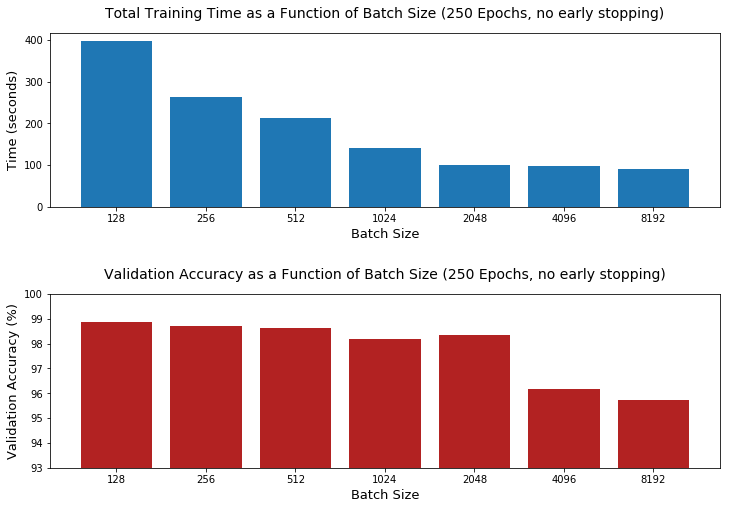

In [157]:
fig, ax = plt.subplots(2, figsize=(12, 8))

# Plot training time as a function of batch size
ax[0].bar(np.arange(len(times)), times)
ax[0].set_title('Total Training Time as a Function of Batch Size (250 Epochs, no early stopping)', size=14, pad=15)
ax[0].set_xlabel('Batch Size', size=13)
ax[0].set_ylabel('Time (seconds)', size=13)
ax[0].set_xticklabels(labels=[0] + batch_sizes)

# Plot validation accuracy as a function of batch size
ax[1].bar(np.arange(len(accs)), np.array(accs)*100, color='firebrick')
ax[1].set_ylim([93, 100])
ax[1].set_title('Validation Accuracy as a Function of Batch Size (250 Epochs, no early stopping)'\
                , size=14, pad=15)
ax[1].set_xlabel('Batch Size', size=13)
ax[1].set_ylabel('Validation Accuracy (%)', size=13)
ax[1].set_xticklabels(labels=[0] + batch_sizes)

fig.subplots_adjust(hspace=.5)

plt.show()

In the figure above, we can observe that the total time spent training this model for 250 epochs decreases as the batch size increases.  Training the model with a batch size of 128 took over 4 times longer than training the model with a batch size of 128.  However, the local gradient estimations from the small batches actually led the model to achieve a higher validation accuracy in the same number of epochs.

___

#### Summary of Experiments

After tuning the model depth, training optimizers, initialization functions, and activation functions, I was able to construct a relatively accurate model (as measured by accuracy on the validation set).  This final model contains 7 layers with 24, 48, 72, 72, 72, 72, and 5 units, respectively, and a final softmax layer.  Each unit uses a relu activation function and the weights associated with each layer were initialized according to the He Normal initialization scheme.  Training was performed by minimizing the categorical cross-entropy loss function using the Adam optimizer.

During this experimentation process, it was interesting to observe how some small changes can significantly improve the performance of the model, while others seemed to make very little difference.  It was clear that for data sets that have a complex structure to them, the feed forward network (without any residual connections, batch normalization, drop-out, etc.) must be made sufficiently deep before a reasonable performance can be observed.

___

#### Evaluation on Held-Out Test Set

Below, I train my final model using a batch size of 512 and then evaluate it on the held-out test set.

In [192]:
# Training the model on the entire training set
# 7 layers, relu activations, he normal initialization, more units in hidden layers
model = Sequential()
model.add(Dense(24, input_shape=(12,), kernel_initializer='he_normal'))
model.add(Activation('relu'))
model.add(Dense(48, kernel_initializer='he_normal'))
model.add(Activation('relu'))
model.add(Dense(72, kernel_initializer='he_normal'))
model.add(Activation('relu'))
model.add(Dense(72, kernel_initializer='he_normal'))
model.add(Activation('relu'))
model.add(Dense(72, kernel_initializer='he_normal'))
model.add(Activation('relu'))
model.add(Dense(72, kernel_initializer='he_normal'))
model.add(Activation('relu'))
model.add(Dense(5, kernel_initializer='he_normal'))
model.add(Activation('softmax'))

model.compile(loss='categorical_crossentropy', optimizer=Adam(), metrics=['categorical_accuracy'])
history = model.fit(X_train, y_train, batch_size=2048, epochs=250, verbose=0, \
                    validation_split=0.2, callbacks=[early_stopper])

In [193]:
# Perform inference on the validation set and report the accuracy and a confusion matrix
y_hat = model.predict(X_test)
y_test = y_test.todense()

# Convert softmax probabilities of the predicted labels to class labels
y_predict = [np.argmax(i) for i in y_hat]
y_test = [np.argmax(i) for i in y_test]

In [195]:
test_accuracy = np.sum(np.array(y_predict) == np.array(y_test))/len(y_test)
print('Test Set Accuracy: {}%'.format(round(test_accuracy*100, 2)))

Test Set Accuracy: 97.12%


In [198]:
print('Confusion Matrix: \n{}'.format(confusion_matrix(y_test, y_predict)))

Confusion Matrix: 
[[15045    15     0    26     2]
 [    8  3252    77   106    79]
 [    1    56 14117    57    81]
 [   19   158    68  3443    65]
 [    0   155   345   115 12400]]


The trained model obtained a classification accuracy of 97.12% on the unseen test-set!  Looking at the confusion matrix, above, the class that was most commonly mispredicted was class 3 (standing up).